<a href="https://colab.research.google.com/github/ekansh2004/PhishingDetection/blob/main/Phishing_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing necessary Python Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from google.colab import drive
import chardet

import warnings
warnings.filterwarnings('ignore')

#Mounting the drive and getting the sms dataset
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/spam.csv'

with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())
encoding = result['encoding']

sdf1 = pd.read_csv(file_path, encoding=encoding)

#Mounting the drive and getting the email dataset
file_path2 = '/content/drive/My Drive/spam_ham_dataset.csv'

with open(file_path2, 'rb') as f1:
    result = chardet.detect(f1.read())

encoding = result['encoding'] if result['encoding'] is not None else 'latin1'

sdf2 = pd.read_csv(file_path2, encoding=encoding)

Mounted at /content/drive


In [2]:
#Checking the sms dataset
sdf1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
#Checking the shape of the sms dataset
sdf1.shape

(5572, 5)

In [4]:
#Checking the email dataset
sdf2.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
#Checking the email dataset
sdf2.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
#Now we are preparing to combine the datasets
#First we are renaming the sms dataset to easily combine with the email dataset
sdf1 = sdf1[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
sdf2 = sdf2[['label', 'text']]

In [7]:
#checking the renamed sms dataset
sdf1.head(5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
#Checking the email dataset
sdf2.head(5)

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [9]:
#Combining the datasets
sdf = pd.concat([sdf1, sdf2], ignore_index=True)

In [10]:
#Checking the combined dataset
sdf.sample(5)

,label,text
2699,ham,Oh baby of the house. How come you dont have a...
9268,ham,Subject: cornhusker for sept\r\ncorrection : t...
2559,ham,I also thk too fast... Xy suggest one not me. ...
8422,spam,Subject: indicter quintus trump verse\r\nhi ul...
2478,ham,Not yet. Just i'd like to keep in touch and it...


In [11]:
#Labeling the data as 0 and 1 instead of their original labels
sdf['label'] = sdf['label'].apply(lambda x: 1 if x == 'spam' else 0)

In [12]:
#Cheking our work
sdf.sample(5)

,label,text
8632,1,Subject: 54 - cy . . . adrian hideout\r\nor ( ...
9946,1,Subject: please confirm your interest .\r\nmy ...
9875,0,Subject: meter 7361 - mtbe plant / egp fuels (...
301,0,"Shit that is really shocking and scary, cant i..."
8409,1,Subject: improve your health today for free\r\...


In [13]:
#Checking for null values
sdf.isnull().sum()

,0
label,0
text,0


In [14]:
#Droping columns with missing values
sdf = sdf.dropna()
print(sdf.isna().sum())

label    0
text     0
dtype: int64


In [15]:
#Checking for duplicate entries
sdf.duplicated().sum()

581

In [16]:
#Dropping duplicate entries
sdf = sdf.drop_duplicates(keep='first')
sdf.duplicated().sum()

0

In [17]:
#Checking the shape of our data
sdf.shape

(10162, 2)

In [18]:
#Getting info about our data
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10162 entries, 0 to 10742
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10162 non-null  int64 
 1   text    10162 non-null  object
dtypes: int64(1), object(1)
memory usage: 238.2+ KB


In [19]:
#Checking the number of entries for each label
sms_type_counts = sdf['label'].value_counts()

In [20]:
print(sms_type_counts)

label
0    8047
1    2115
Name: count, dtype: int64


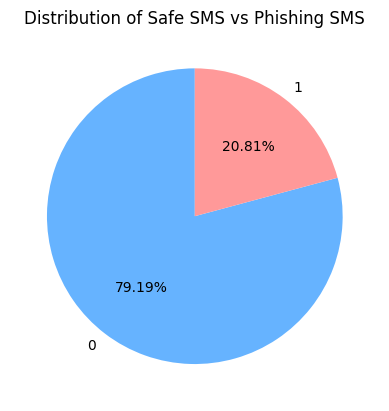

In [21]:
#Plotting them as a pie chart
plt.pie(sms_type_counts, labels=sms_type_counts.index, autopct='%0.2f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of Safe SMS vs Phishing SMS')
plt.show()

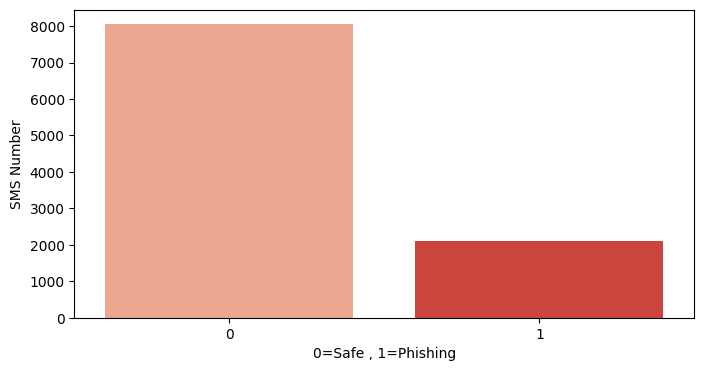

In [22]:
#Plotting it as a bar graph
plt.figure(figsize=(8,4))
sns.countplot(data=sdf, x='label', palette='Reds')
plt.xlabel("0=Safe , 1=Phishing")
plt.ylabel("SMS Number")
plt.show()

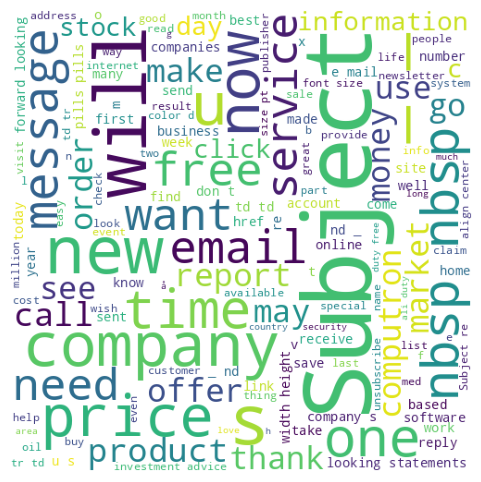

In [23]:
#Generating a word cloud
from wordcloud import WordCloud

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
phishing_worldcloud = wc.generate(" ".join(sdf[sdf['label'] == 1]['text']))

plt.figure(figsize=(15, 6))
plt.imshow(phishing_worldcloud)
plt.axis('off')
plt.show()

In [28]:
#Here we are creating a function to clean the data
import string
import nltk
from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


ps = PorterStemmer()

def cleaned_data(text):
    text = text.lower()

    text = re.sub('[^a-zA-Z0-9]', ' ', text)

    text = re.sub(r'http\S+', '', text)
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
#Testing the cleaning function
cleaned_data("Hello! Visit https://example.com for 50% OFF on your purchase!!! Don't miss out. Call us NOW at 123-456-7890 or email at sales@example.com.")

'hello visit exampl com 50 purchas miss call us 123 456 7890 email sale exampl com'

In [30]:
#Cleaning the entire data
def cleaned_data_with_counter(row, counter=[0]):
    counter[0] += 1
    if counter[0] % 500 == 0:
        print(f"Processed {counter[0]} rows")
    return cleaned_data(row['text'])

sdf['cleaned_text'] = sdf.apply(cleaned_data_with_counter, axis=1)

Processed 500 rows
Processed 1000 rows
Processed 1500 rows
Processed 2000 rows
Processed 2500 rows
Processed 3000 rows
Processed 3500 rows
Processed 4000 rows
Processed 4500 rows
Processed 5000 rows
Processed 5500 rows
Processed 6000 rows
Processed 6500 rows
Processed 7000 rows
Processed 7500 rows
Processed 8000 rows
Processed 8500 rows
Processed 9000 rows
Processed 9500 rows
Processed 10000 rows


In [31]:
#Checking the cleaned data
sdf.sample(5)

,label,text,cleaned_text
9804,0,Subject: pricing issue for 5 / 00 production -...,subject price issu 5 00 product duke energi pr...
5331,0,X course it 2yrs. Just so her messages on mess...,x cours 2yr messag messeng lik r send
873,0,Ugh its been a long day. I'm exhausted. Just w...,ugh long day exhaust want cuddl take nap
7123,0,"Subject: 1601\r\ndaren , i need deal ticket 74...",subject 1601 daren need deal ticket 745546 ext...
8774,1,Subject: time sensitive . . . refer to # f 781...,subject time sensit refer f 781557 hi sent ema...


In [ ]:
#Droping the original text column
sdf = sdf[['label', 'cleaned_text']]
sdf.sample(5)

In [32]:
save_path = '/content/drive/My Drive/cleaned_sms.csv'
sdf.to_csv(save_path, index=False)
print('cleaned_sms saved')

cleaned_sms saved


In [33]:
file_path3 = '/content/drive/My Drive/cleaned_sms.csv'
sd = pd.read_csv(file_path3)

In [34]:
#Now we are again droping duplicates
sd = sd.drop_duplicates(keep='first')
sd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10162 entries, 0 to 10161
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         10162 non-null  int64 
 1   text          10162 non-null  object
 2   cleaned_text  10156 non-null  object
dtypes: int64(1), object(2)
memory usage: 238.3+ KB


In [35]:
sd.sample(5)

,label,text,cleaned_text
6569,1,"Subject: \r\nhi again ,\r\nhere is juanita hol...",subject hi juanita holt wite accept mortgag ap...
125,0,"Just so that you know,yetunde hasn't sent mone...",know yetund sent money yet sent text bother se...
4331,0,How come i din c Ì_... Yup i cut my hair...,come din c yup cut hair
3034,0,"Oh, yes, I've just been a little under the wea...",oh ye littl weather kind coccoon home
4809,0,Ok... Then r we meeting later?,ok r meet later


In [36]:
#Getting the most common words in a phising sms or email
from collections import Counter
phishing = []
for msg in sd[sd['label'] == 1]['cleaned_text'].tolist():
    for word in msg.split():
        phishing.append(word)

Counter(phishing).most_common(10)


[('subject', 1623),
 ('3', 1266),
 ('2', 1037),
 ('com', 1036),
 ('http', 1000),
 ('compani', 921),
 ('1', 804),
 ('price', 746),
 ('0', 691),
 ('www', 669)]

In [37]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=5000)

In [38]:
sd = sd.dropna(subset=['cleaned_text'])
X = tfidf.fit_transform(sd['cleaned_text']).toarray()
X.shape

(10156, 5000)

In [39]:
print("Total features:", len(tfidf.get_feature_names_out()))

Total features: 5000


In [40]:
non_zero_indices = np.nonzero(X[0])[0]
non_zero_words = tfidf.get_feature_names_out()[non_zero_indices]
non_zero_tfidf_scores = X[0, non_zero_indices]

for word, score in zip(non_zero_words, non_zero_tfidf_scores):
    print(f"Word: {word}, TF-IDF Score: {score}")

Word: amor, TF-IDF Score: 0.49568311437451135
Word: avail, TF-IDF Score: 0.2441749921881602
Word: crazi, TF-IDF Score: 0.40084018598084836
Word: go, TF-IDF Score: 0.19512175292817238
Word: got, TF-IDF Score: 0.24715634995634367
Word: great, TF-IDF Score: 0.2615046171734516
Word: la, TF-IDF Score: 0.33763995458702356
Word: point, TF-IDF Score: 0.26014640464755734
Word: wat, TF-IDF Score: 0.32053986817881885
Word: world, TF-IDF Score: 0.2864224958824368


In [41]:
y = sd['label'].values

In [42]:
#Spliting the data into Test and train
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=2)

In [43]:
print(X_train.shape, X_test.shape)

(8124, 5000) (2032, 5000)


In [44]:
#Training the random forest classifier and getting its accuracy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))

0.968503937007874
[[1618   10]
 [  54  350]]
0.9686017866187779


In [45]:
#We are now saving the model
from joblib import dump, load

dump(tfidf, open('vectorizer.pkl', 'wb'))
dump(rf, open('model.pkl', 'wb'))

In [48]:
#Loading the model and Running queries on it
loaded_model = load("model.pkl")
loaded_vectorizer = load("vectorizer.pkl")

input_messages = np.array([
    "Congratulations! You've been selected for a free vacation to the Bahamas. Click to claim your prize.",
    "Please check the attached report for the meeting tomorrow.",
    "Free entry into our contest to win a brand new car! Click here now.",
    "Meeting scheduled for 10 AM. Don’t forget the necessary documents.",
])

vectorized_messages = loaded_vectorizer.transform(input_messages)
print(vectorized_messages.shape)
predictions = loaded_model.predict(vectorized_messages)
print(predictions)

(4, 5000)
[1 0 1 0]
